In [ ]:
!pip install matplotlib keras tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping and renaming file

In [ ]:
import os

# Set the path to your dataset.zip file
zip_path = '/content/drive/MyDrive/LATEST_DATASETS/CNN_DATASETS_WITHOUT_OTHER.zip'

# Set the output directory where the files will be extracted
output_dir = '/content/'

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Unzip the file
!unzip -q "$zip_path" -d "$output_dir"

#renaming to data
set
current_folder_path = '/content/CNN_DATASETS_WITHOUT_OTHER'

# Desired new folder name
new_folder_path = '/content/datasets'

# Rename the folder
os.rename(current_folder_path, new_folder_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Multiply, Reshape, SpatialDropout2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:

# Parameters
num_classes = 4  # HDPE, PET, PP, PS, others
input_shape = (224, 224, 3)
batch_size = 16
epochs = 100

## Residual Block

In [ ]:
def residual_block(x, filters):
    shortcut = x

    # Adjust shortcut if input and output shapes differ
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = layers.add([shortcut, x])
    return layers.Activation('swish')(x)


## SE Block

In [ ]:
# Squeeze-and-Excitation (SE) Block
def se_block(x, ratio=16):
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='swish')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([x, se])

In [ ]:


# Create Modern CNN Model
def create_modern_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(32, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Backbone
    x = residual_block(x, 64)
    x = se_block(x)
    x = SpatialDropout2D(0.2)(x)

    x = residual_block(x, 128)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='swish', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    return model

In [ ]:
# # Total parameters
# total_params = model.count_params()
# print(f"Total parameters: {total_params}")

# # Trainable parameters
# trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
# print(f"Trainable parameters: {trainable_params}")

# # Non-trainable parameters
# non_trainable_params = sum([K.count_params(w) for w in model.non_trainable_weights])
# print(f"Non-trainable parameters: {non_trainable_params}")


In [ ]:
model=create_modern_cnn(input_shape, num_classes)
model.summary()

NameError: name 'lr_schedule' is not defined

In [ ]:


# Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/datasets/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/datasets/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/datasets/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 80396 images belonging to 4 classes.
Found 22972 images belonging to 4 classes.
Found 11488 images belonging to 4 classes.


In [ ]:
# # Callbacks
# checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping Callback
early_stop = EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy'
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True
)

# ModelCheckpoint to save best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train Model with EarlyStopping and Checkpoint
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2282/2282 ━━━━━━━━━━━━━━━━━━━━ 122s 46ms/step - accuracy: 0.5886 - loss: 1.2521 - val_accuracy: 0.6778 - val_loss: 0.9903
Epoch 2/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 98s 43ms/step - accuracy: 0.7857 - loss: 0.8280 - val_accuracy: 0.7757 - val_loss: 0.8525
Epoch 3/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.8503 - loss: 0.7127 - val_accuracy: 0.8585 - val_loss: 0.6804
Epoch 4/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.8877 - loss: 0.6474 - val_accuracy: 0.7979 - val_loss: 0.7894
Epoch 5/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.9050 - loss: 0.6182 - val_accuracy: 0.8965 - val_loss: 0.6252
Epoch 6/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 93s 41ms/step - accuracy: 0.9193 - loss: 0.5899 - val_accuracy: 0.5263 - val_loss: 1.4712
Epoch 7/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.9305 - loss: 0.5653 - val_accuracy: 0.8714 - val_loss: 0.6687
Epoch 8/100
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.9364 - lo

In [ ]:



# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


NameError: name 'model' is not defined

In [ ]:
model.save("plastic_classification.keras")

# SAVING THE HISTORY OF COMPLETED TRAINING

In [ ]:
import json
import tensorflow as tf
# Create a directory for saving the history
os.makedirs('/content/training_logs', exist_ok=True)

# Save the history in that folder
with open('/content/training_logs/training_history.json', 'w') as f:
    json.dump(history.history, f)

print("Training history saved to /content/training_logs/training_history.json")


## OR

In [ ]:
import os
import pickle

# Create the directory to save the model history if it doesn't exist
os.makedirs('/content/saved_models', exist_ok=True)

# Save the training history with pickle
with open('/content/saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved to /content/saved_models/training_history.pkl")


# LOADING THE HISTORY

# EVALUATION PARTS

# loading the saved model ....

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the HDF5 file
model = load_model('/content/best_model.keras')


# Verify the model has been loaded correctly
model.summary()

In [ ]:
model.compile(optimizer=None)  # This removes the optimizer state


In [ ]:


# Verify the model has been loaded correctly
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 32)   │          4,736 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 55, 55, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 55, 55, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 55, 55, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 55, 55, 64)     │          2,112 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 55, 55, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 55, 55, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 55, 55, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 55, 55, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 55, 55, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ activation_2[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├──────────────────────

 Total params: 365,328 (1.39 MB)

 Trainable params: 364,112 (1.39 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
# Save the model without optimizer
model.save("mode_without_optimizer.keras", include_optimizer=False)

print("Model saved without optimizer parameters.")

Model saved without optimizer parameters.


#TRAIN/VAL LOSS GRAPH

In [ ]:
import pickle

# Load history from a pickle file
with open("/content/drive/MyDrive/residual_net_training_results/Training History.pkl", "rb") as f:
    history = pickle.load(f)

print(history.keys())  # Check available keys (e.g., loss, val_loss, accuracy, etc.)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
import numpy as np

# Get validation loss and find the best epoch
val_loss = history["val_loss"]  # Or use "val_accuracy" if needed
best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1

print(f"Best epoch: {best_epoch}, with val_loss: {val_loss[best_epoch-1]}")


Best epoch: 99, with val_loss: 0.38647592067718506


In [ ]:
# Find last trained epoch
last_epoch = len(history["loss"])
print(f"{last_epoch}")

100


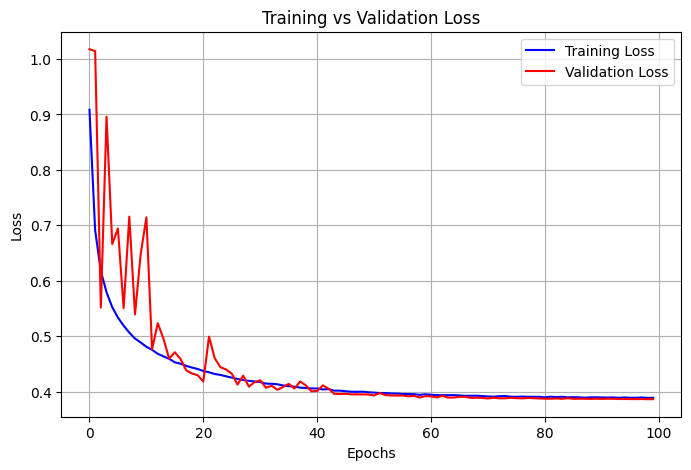

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss
train_loss = history["loss"]
val_loss = history["val_loss"]

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
# (from model.fit)

# Get training and validation loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#CONFUSION MATRIX


718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step


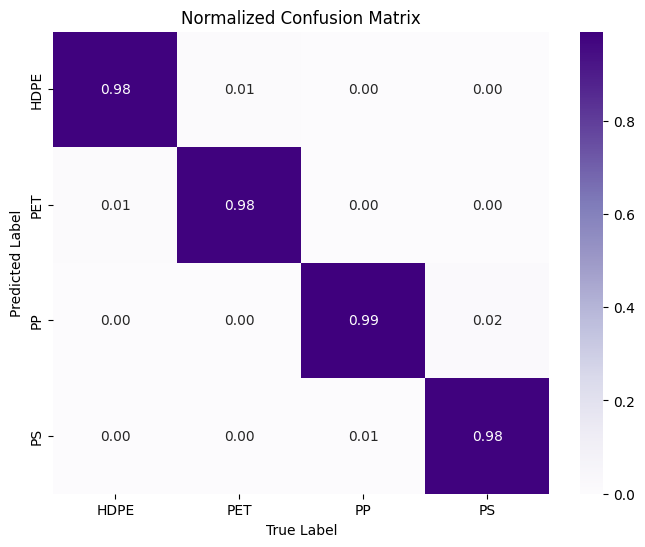

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = test_generator.classes  # Extract true labels

# Get class names (to label the confusion matrix)
class_names = list(test_generator.class_indices.keys())

# Get predictions from model
pred_probs = model.predict(test_generator)  # Predict probabilities
pred_labels = np.argmax(pred_probs, axis=1) # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix_s= confusion_matrix(true_labels, pred_labels)
conf_matrix=conf_matrix_s.transpose()


# Normalize by column (true class)
conf_matrix_norm_col = conf_matrix.astype("float") / conf_matrix.sum(axis=0, keepdims=True)  # Column-wise normalization

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm_col, annot=True, fmt=".2f", cmap="Purples", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("True Label")
plt.ylabel("Predicted Label")

plt.title("Normalized Confusion Matrix")
plt.show()



718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step


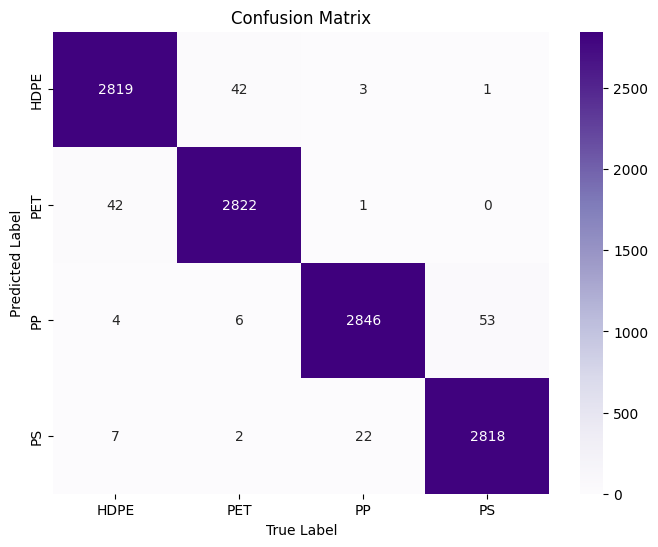

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = test_generator.classes  # Extract true labels

# Get class names (to label the confusion matrix)
class_names = list(test_generator.class_indices.keys())

# Get predictions from model
pred_probs = model.predict(test_generator)  # Predict probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix and swap axes
conf_matrix = confusion_matrix(true_labels, pred_labels).T  # Transpose to swap X and Y

# Plot transposed confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("True Label")  # Now, True labels are on X-axis
plt.ylabel("Predicted Label")  # Predicted labels are on Y-axis
plt.title("Confusion Matrix")
plt.show()


#F1 CONFIDENCE

718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step
[0 0 0 ... 3 3 3]


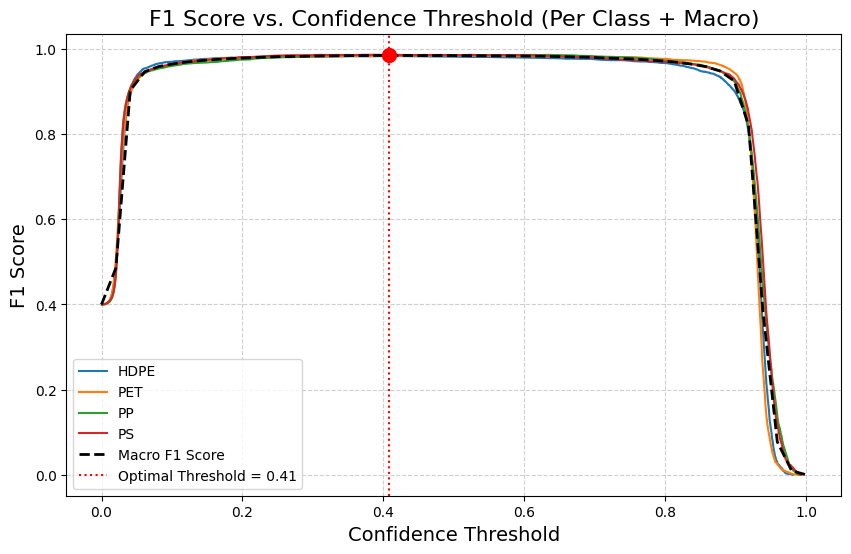

Optimal Confidence Threshold: 0.4082 (Max Macro F1: 0.9840)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

# Get predictions on the test set (probabilities)
y_pred_probs = model.predict(test_generator)

# Get true labels for the test set
y_true = test_generator.classes
print(y_true)

# Define class labels
class_labels = {0: 'HDPE', 1: 'PET', 2: 'PP', 3: 'PS'}

# Create figure for plotting
plt.figure(figsize=(10, 6))

# Store macro F1 scores at common thresholds
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_f1_scores = []
threshold_f1_dict = {t: [] for t in common_thresholds}

# Loop through each class to calculate F1 score at different thresholds
for class_index, class_name in class_labels.items():
    # Get probabilities for the current class
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Calculate F1 score for each threshold (avoid division by zero)
    f1_scores = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    # Store class-wise F1 scores at common thresholds (interpolating where needed)
    interpolated_f1 = np.interp(common_thresholds, thresholds, f1_scores[:-1])
    for i, t in enumerate(common_thresholds):
        threshold_f1_dict[t].append(interpolated_f1[i])

    # Plot per-class F1 score curve
    plt.plot(thresholds, f1_scores[:-1], label=f"{class_name}")

# Compute Macro F1 Score at each common threshold
for t in common_thresholds:
    macro_f1_scores.append(np.mean(threshold_f1_dict[t]))

# Find the optimal threshold (maximizing macro F1)
optimal_threshold = common_thresholds[np.argmax(macro_f1_scores)]
optimal_f1 = max(macro_f1_scores)

# Plot Macro F1 Score Curve
plt.plot(common_thresholds, macro_f1_scores, 'k--', label="Macro F1 Score", linewidth=2)

# Mark the optimal threshold on the plot
plt.axvline(x=optimal_threshold, color='red', linestyle=':', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_f1, color='red', s=100, zorder=3)

# Labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.title("F1 Score vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print the optimal threshold
print(f"Optimal Confidence Threshold: {optimal_threshold:.4f} (Max Macro F1: {optimal_f1:.4f})")


# PRECISION CONFIDENCE GRAPH


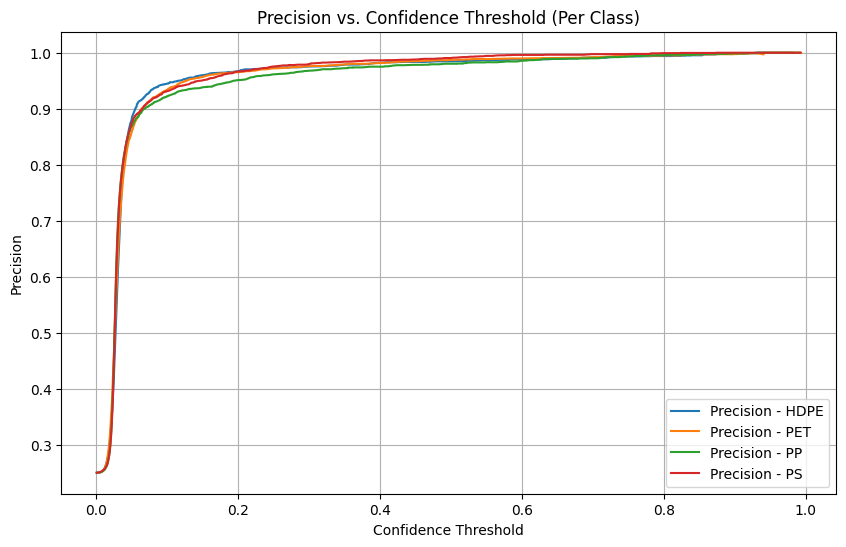

In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot Precision vs. Confidence Threshold for each class
for class_index in class_labels.keys():
    y_probs = y_pred_probs[:, class_index]
    precision, recall, class_thresholds = precision_recall_curve(y_true == class_index, y_probs)

    plt.plot(class_thresholds, precision[:-1], label=f"Precision - {class_labels[class_index]}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold (Per Class)")
plt.legend()
plt.grid(True)
plt.show()


#RECALL CONFIDENCE


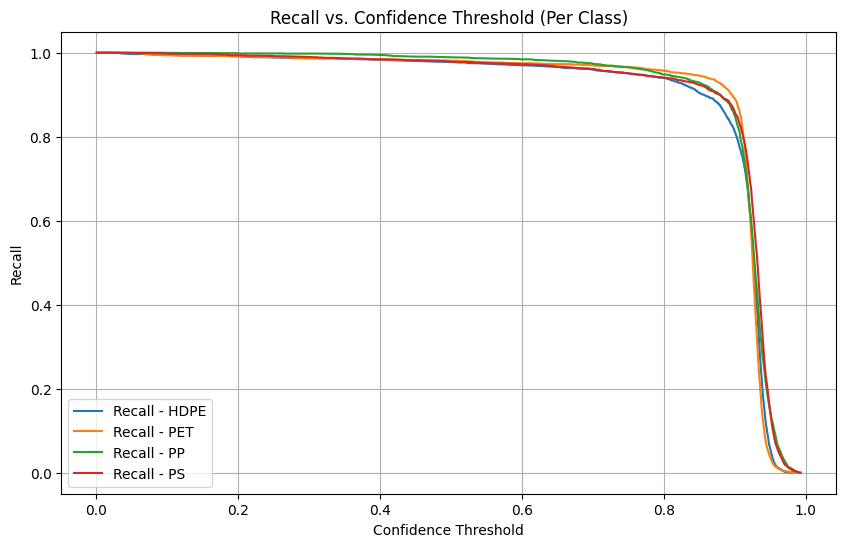

In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot Recall vs. Confidence Threshold for each class
for class_index in class_labels.keys():
    y_probs = y_pred_probs[:, class_index]
    precision, recall, class_thresholds = precision_recall_curve(y_true == class_index, y_probs)

    plt.plot(class_thresholds, recall[:-1], label=f"Recall - {class_labels[class_index]}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold (Per Class)")
plt.legend()
plt.grid(True)
plt.show()


#PRECISION RECALL

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step


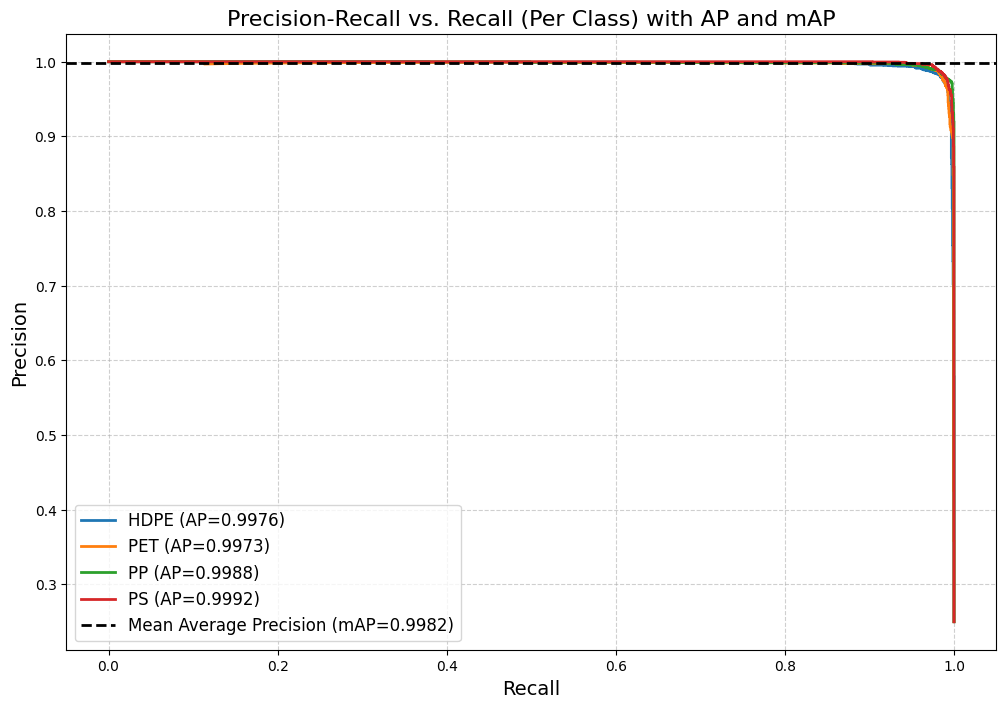

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Example: Get predictions (probabilities) from the model
y_pred_probs = model.predict(test_generator)  # Shape: (num_samples, num_classes)

# True labels for the test set
y_true = test_generator.classes  # Shape: (num_samples,)

# Define class labels
class_labels = {0: 'HDPE', 1: 'PET', 2: 'PP', 3: 'PS'}

# Store Average Precision (AP) for each class
average_precisions = []

# Create figure for plotting
plt.figure(figsize=(12, 8))

# Loop through each class to calculate Precision-Recall and AP at different thresholds
for class_index, class_name in class_labels.items():
    # Get probabilities for the current class
    y_probs = y_pred_probs[:, class_index]

    # Check if the class exists in `y_true`
    if np.sum(y_true == class_index) == 0:
        print(f"Skipping class {class_name} (No instances found in test set)")
        continue

    # Calculate precision, recall, and thresholds for the current class
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Calculate Average Precision (AP) for the current class
    ap = average_precision_score(y_true == class_index, y_probs)
    average_precisions.append(ap)

    # Plot per-class Precision-Recall curve with AP annotation
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.4f})", linewidth=2)

# Calculate Macro Average Precision (mAP) by averaging the APs across all classes
mAP = np.mean(average_precisions)

# Plot Macro Average Precision (mAP) as a horizontal line
plt.axhline(y=mAP, color='black', linestyle='--', linewidth=2, label=f"Mean Average Precision (mAP={mAP:.4f})")

# Plot labels, title, and legend for the plot
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall vs. Recall (Per Class) with AP and mAP", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#PRECISION CONFIDENCE WITH ALL CLASS TOGETHER

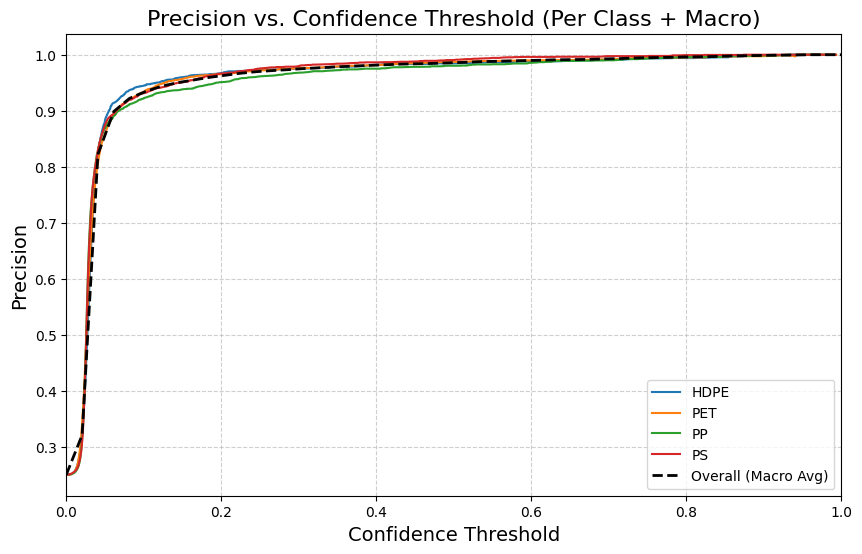

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize lists to store per-class precision scores
class_precision_scores = {class_index: [] for class_index in class_labels.keys()}
class_thresholds = {}

# Create figure
plt.figure(figsize=(10, 6))

# Loop through classes and calculate precision for each class at different thresholds
for class_index, class_name in class_labels.items():
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Store precision and thresholds
    class_precision_scores[class_index] = precision[:-1]  # Exclude last threshold value (corresponds to precision=1)
    class_thresholds[class_index] = thresholds  # Store corresponding thresholds

    # Plot per-class precision
    plt.plot(thresholds, precision[:-1], label=f"{class_name}")

# Define common thresholds for interpolation
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_precision_scores = []

# Compute Macro Precision at Each Common Threshold
for t in common_thresholds:
    precisions_at_threshold = []

    for class_index in class_labels.keys():
        # Get thresholds for this class
        thresholds = class_thresholds[class_index]

        # If `t` is lower than the minimum threshold, use the first precision value
        if t < thresholds[0]:
            precision_value = class_precision_scores[class_index][0]
        else:
            # Find closest threshold index or interpolate precision
            precision_value = np.interp(t, thresholds, class_precision_scores[class_index])

        precisions_at_threshold.append(precision_value)

    # Compute Macro Precision (average of class-wise precision at `t`)
    macro_precision = np.mean(precisions_at_threshold)
    macro_precision_scores.append(macro_precision)

# Plot the macro precision curve
plt.plot(common_thresholds, macro_precision_scores, 'k--', label="Overall (Macro Avg)", linewidth=2)

# Add labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0, 1])
plt.show()


#RECALL CONFIDENCE WITH ALL CLASS TOGETHER

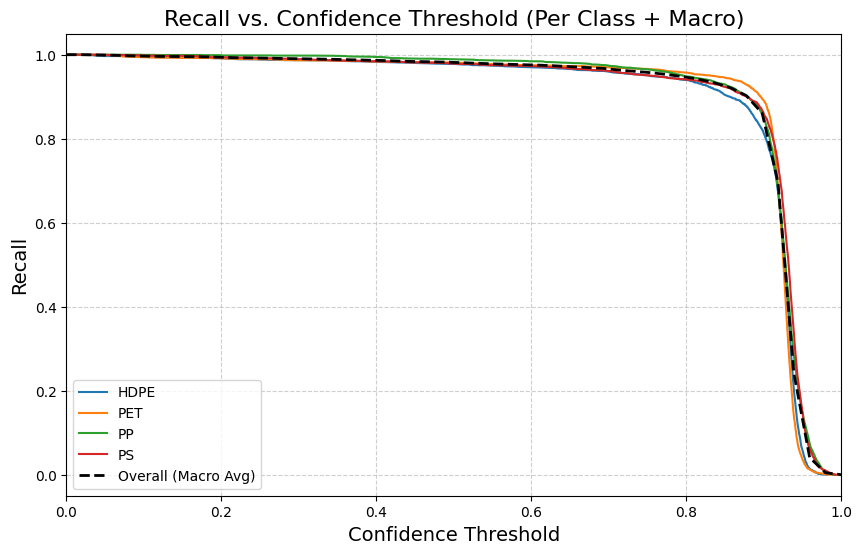

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize lists to store per-class recall scores
class_recall_scores = {class_index: [] for class_index in class_labels.keys()}
class_thresholds = {}

# Create figure
plt.figure(figsize=(10, 6))

# Loop through classes and calculate recall for each class at different thresholds
for class_index, class_name in class_labels.items():
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Store recall and thresholds
    class_recall_scores[class_index] = recall[:-1]  # Exclude last threshold value (corresponds to recall=0)
    class_thresholds[class_index] = thresholds  # Store corresponding thresholds

    # Plot per-class recall
    plt.plot(thresholds, recall[:-1], label=f"{class_name}")

# Define common thresholds for interpolation
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_recall_scores = []

# Compute Macro Recall at Each Common Threshold
for t in common_thresholds:
    recalls_at_threshold = []

    for class_index in class_labels.keys():
        # Get thresholds for this class
        thresholds = class_thresholds[class_index]

        # If `t` is lower than the minimum threshold, use the first recall value
        if t < thresholds[0]:
            recall_value = class_recall_scores[class_index][0]
        else:
            # Find closest threshold index or interpolate recall
            recall_value = np.interp(t, thresholds, class_recall_scores[class_index])

        recalls_at_threshold.append(recall_value)

    # Compute Macro Recall (average of class-wise recall at `t`)
    macro_recall = np.mean(recalls_at_threshold)
    macro_recall_scores.append(macro_recall)

# Plot the macro recall curve
plt.plot(common_thresholds, macro_recall_scores, 'k--', label="Overall (Macro Avg)", linewidth=2)

# Add labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Recall vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0, 1])
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("plastic_classification.keras")

# Class labels
class_labels = {0: 'HDPE', 1: 'Other', 2: 'PET', 3: 'PP', 4: 'PS'}

# Path to the test image
image_path = "/content/datasets/test/HDPE/0010_a02b01c1d0e0f1g0h0_jpg.rf.e8cd4e940330308ac24656e2840a771e_box_0.jpg"

# Preprocess the image
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_label = class_labels[predicted_class_index]

# Display the image with labels
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")  # actual_label needs to be obtained
plt.axis('off')
plt.show()